# Pipeline

Cette pipeline va utiliser différents modèles d'IA afin d'enlever des filigranes présents sur des images pour ensuite les déflouter et augmenter leur résolution.

Nous allons présenter le principe d'utilisation au travers d'une image de notre dataset

# Remove Watermarks

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import cv2
import torch
from diffusers import DiffusionPipeline

/opt/anaconda3/envs/wd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Nous disposons d'un dataset d'images avec des watermarks et de notre modèle "cnn_encoder.h5" pour les retirer

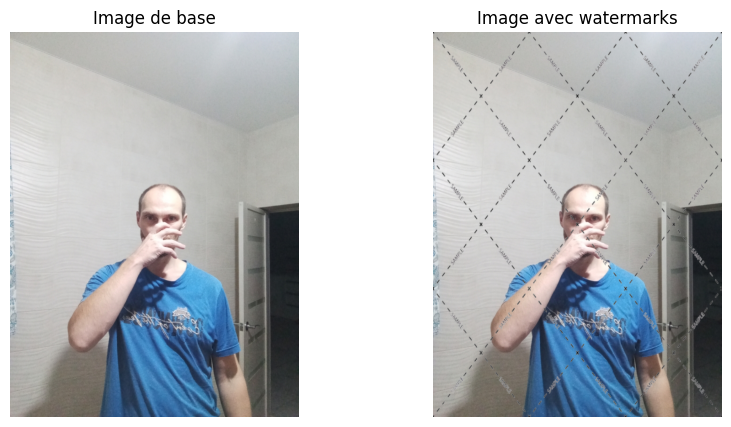

In [3]:
nw_image = "data/base_dataset/80a05f5b-59d8-48d1-89b0-00ac27356bed.png"
w_image = "data/watermarked_dataset/80a05f5b-59d8-48d1-89b0-00ac27356bed.png"

img_nw = mpimg.imread(nw_image)
img_w = mpimg.imread(w_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_nw)
axs[0].set_title('Image de base')
axs[0].axis('off')

axs[1].imshow(img_w)
axs[1].set_title('Image avec watermarks')
axs[1].axis('off')

plt.show()

In [4]:
# taille des images
print("Taille de l'image de base : ", img_nw.shape)
print("Taille de l'image avec watermarks : ", img_w.shape)

Taille de l'image de base :  (720, 540, 3)
Taille de l'image avec watermarks :  (720, 540, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


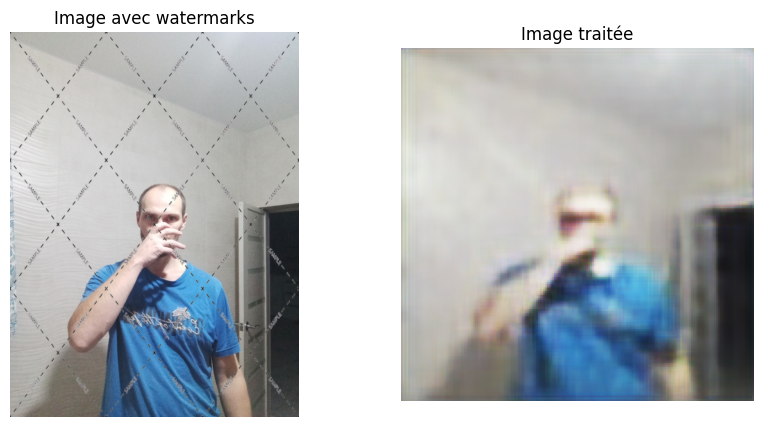

In [5]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

encoder = load_model('models/cnn_encoder.h5', custom_objects={'mse': mse})

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  
    return np.expand_dims(img_array, axis=0)

input_size = (196, 196)

image = preprocess_image(w_image, input_size)

cleaned_image = encoder.predict(image)
cleaned_image = np.clip(cleaned_image, 0, 1)
cleaned_image = np.squeeze(cleaned_image, axis=0)
cleaned_image = np.uint8(cleaned_image * 255)
cleaned_image = Image.fromarray(cleaned_image)

# sauvegarde de l'image
cleaned_image.save('data/cleaned_image.png')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_w)
axs[0].set_title('Image avec watermarks')
axs[0].axis('off')

axs[1].imshow(cleaned_image)
axs[1].set_title('Image traitée')
axs[1].axis('off')

plt.show()

In [6]:
# taille de l'image
print("Taille de l'image traitée : ", cleaned_image.size)

Taille de l'image traitée :  (196, 196)


# Deblurring

Dans cette partie, nous allons utiliser notre model d'autoencodeur de défloutage développé dans le notebook 'deblurring.ipynb'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/opt/anaconda3/envs/wd/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


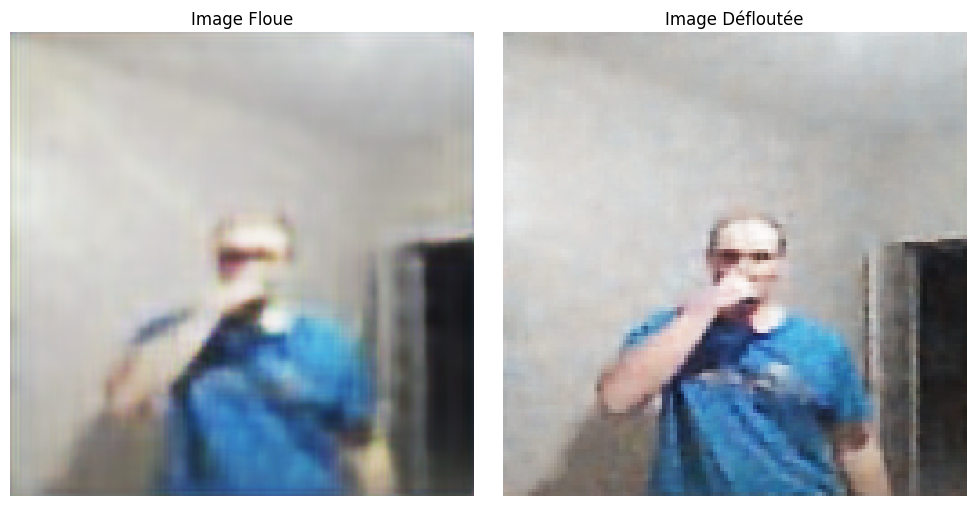

Défloutage terminé, image sauvegardée sous 'deblurred_output.png'.


In [7]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image).astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def postprocess_image(image):
    image = image[0]
    image = np.clip(image * 255.0, 0, 255).astype(np.uint8)
    return image

model = tf.keras.models.load_model("models/autoencoder_model.keras")

# nous reprenons notre image sans watermarks enregistrée précédemment
image_path = "data/cleaned_image.png"

blurry_image = preprocess_image(image_path)

deblurred_image = model.predict(blurry_image)
deblurred_image = postprocess_image(deblurred_image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

ax[0].imshow(original_image)
ax[0].set_title("Image Floue")
ax[0].axis("off")

ax[1].imshow(deblurred_image)
ax[1].set_title("Image Défloutée")
ax[1].axis("off")

plt.tight_layout()
plt.show()

print("Défloutage terminé, image sauvegardée sous 'deblurred_output.png'.")

In [8]:
print("Taille de l'image défloutée : ", deblurred_image.shape)

Taille de l'image défloutée :  (128, 128, 3)


# Upscaling

Dans cette partie nous allons utiliser un modèle pré entrainé (Latent Diffusion Models (LDM) for super-resolution) afin de faire de l'upscaling sur notre image défloutée
https://huggingface.co/CompVis/ldm-super-resolution-4x-openimages 

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/nico/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization

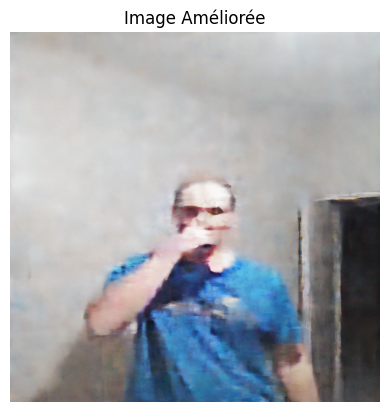

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"

pipeline = DiffusionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

if deblurred_image.ndim == 4:
    deblurred_image = deblurred_image[0]

low_res_img = Image.fromarray(deblurred_image.astype(np.uint8))

low_res_img = low_res_img.resize((128, 128))

upscaled_image = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]

plt.imshow(upscaled_image)
plt.title("Image Améliorée")
plt.axis('off')
plt.show()

In [11]:
print("Taille de l'image améliorée : ", upscaled_image.size)

Taille de l'image améliorée :  (512, 512)
